## Code Modules & Functions

In [1]:
!pip install tensorflow_datasets

     |████████████████████████████████| 3.3 MB 4.7 MB/s 


In [2]:
import warnings; warnings.filterwarnings('ignore')
import numpy as np,pandas as pd,pylab as pl
import h5py,os,tensorflow as tf
from tensorflow import image as timage
import tensorflow_datasets as tfds
import tensorflow_hub as th

In [3]:
def resize_display(x_train,y_train,
                   x_test,y_test,pixels):
    x_train=np.array(timage.resize(x_train,[pixels,pixels]))
    x_test=np.array(timage.resize(x_test,[pixels,pixels]))
    N=len(y_train); shuffle_ids=np.arange(N)
    np.random.RandomState(12).shuffle(shuffle_ids)
    x_train,y_train=x_train[shuffle_ids],y_train[shuffle_ids]
    N=len(y_test); shuffle_ids=np.arange(N)
    np.random.RandomState(23).shuffle(shuffle_ids)
    x_test,y_test=x_test[shuffle_ids],y_test[shuffle_ids]
    n=int(len(x_test)/2)
    x_valid,y_valid=x_test[:n],y_test[:n]
    x_test,y_test=x_test[n:],y_test[n:]
    df=pd.DataFrame([[x_train.shape,x_valid.shape,x_test.shape],
                     [x_train.dtype,x_valid.dtype,x_test.dtype],
                     [y_train.shape,y_valid.shape,y_test.shape],
                     [y_train.dtype,y_valid.dtype,y_test.dtype]],
                    columns=['train','valid','test'],
                    index=['image shape','image type',
                           'label shape','label type'])
    display(df)    
    return [[x_train,x_valid,x_test],
            [y_train,y_valid,y_test]]

## Data

In [4]:
splits=['train[:80%]','train[80%:]']
tfds.disable_progress_bar()
(raw_train,raw_test),metadata=\
tfds.load('cats_vs_dogs:4.0.0',split=splits,
          with_info=True,as_supervised=True)

Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteZU8O5M/cats_vs_dogs-train.tfrecord
Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


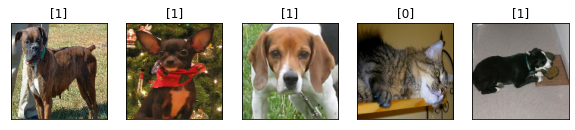

In [5]:
s=128; ntest=4652
ntrain=23262-ntest
x_test=np.zeros((ntest,s,s,3),dtype='float32')
y_test=np.zeros((ntest,1),dtype='int32')
x_train=np.zeros((ntrain,s,s,3),dtype='float32')
y_train=np.zeros((ntrain,1),dtype='int32')
i=0
for f,t in raw_test.take(ntest):
    f=timage.resize(f,[s,s])
    x_test[i,:]=f/255
    y_test[i,:]=t; i+=1
i=0
for f,t in raw_train.take(ntrain):
    f=timage.resize(f,[s,s])
    x_train[i,:]=f/255
    y_train[i,:]=t; i+=1
fig=pl.figure(figsize=(10,4))   
for i in range(5):    
    ax=fig.add_subplot(1,5,i+1,\
    xticks=[],yticks=[],title=y_train[i])
    ax.imshow((x_train[i]));

In [6]:
pd.DataFrame([[x_train.shape,x_test.shape],
              [x_train.dtype,x_test.dtype],
              [y_train.shape,y_test.shape],
              [y_train.dtype,y_test.dtype]],               
             columns=['train','test'])

,train,test
0,"(18610, 128, 128, 3)","(4652, 128, 128, 3)"
1,float32,float32
2,"(18610, 1)","(4652, 1)"
3,int32,int32


In [7]:
with h5py.File('CatDogImages.h5','w') as f:
    f.create_dataset('train_images',data=x_train)
    f.create_dataset('train_labels',data=y_train)
    f.create_dataset('test_images',data=x_test)
    f.create_dataset('test_labels',data=y_test)
os.stat('CatDogImages.h5')

os.stat_result(st_mode=33188, st_ino=131083, st_dev=1793, st_nlink=1, st_uid=0, st_gid=0, st_size=4573592440, st_atime=1592058105, st_mtime=1592058120, st_ctime=1592058120)

In [8]:
[[x_train,x_valid,x_test],
 [y_train,y_valid,y_test]]=\
resize_display(x_train,y_train,x_test,y_test,96)

,train,valid,test
image shape,"(18610, 96, 96, 3)","(2326, 96, 96, 3)","(2326, 96, 96, 3)"
image type,float32,float32,float32
label shape,"(18610, 1)","(2326, 1)","(2326, 1)"
label type,int32,int32,int32


In [9]:
del raw_train,raw_test

['test_images', 'test_labels', 'train_images', 'train_labels']


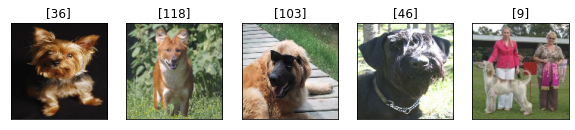

In [10]:
fpath='../input/image-classification-for-biospecies/'
f=h5py.File(fpath+'DogBreedImages.h5','r')
keys=list(f.keys()); print(keys)
x_test2=np.array(f[keys[0]]); y_test2=np.array(f[keys[1]])
x_train2=np.array(f[keys[2]]); y_train2=np.array(f[keys[3]])
fig=pl.figure(figsize=(10,4))   
for i in range(5):    
    ax=fig.add_subplot(1,5,i+1,\
    xticks=[],yticks=[],title=y_train2[i])
    ax.imshow((x_train2[i]));

In [11]:
[[x_train2,x_valid2,x_test2],
 [y_train2,y_valid2,y_test2]]=\
resize_display(x_train2,y_train2,x_test2,y_test2,96)

,train,valid,test
image shape,"(12000, 96, 96, 3)","(4290, 96, 96, 3)","(4290, 96, 96, 3)"
image type,float32,float32,float32
label shape,"(12000, 1)","(4290, 1)","(4290, 1)"
label type,int32,int32,int32


## NN Examples

In [12]:
def premodel(pix,den,mh,lbl,activ,loss):
    model=tf.keras.Sequential([
        tf.keras.layers.Input((pix,pix,3),
                              name='input'),
        th.KerasLayer(mh,trainable=True),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(den,activation='relu'),
        tf.keras.layers.Dropout(rate=.5),
        tf.keras.layers.Dense(lbl,activation=activ)])
    model.compile(optimizer='adam',
                  metrics=['accuracy'],loss=loss)
    display(model.summary())
    return model
def cb(fw):
    early_stopping=tf.keras.callbacks\
    .EarlyStopping(monitor='val_loss',patience=20,verbose=2)
    checkpointer=tf.keras.callbacks\
    .ModelCheckpoint(filepath=fw,save_best_only=True,verbose=2)
    lr_reduction=tf.keras.callbacks\
    .ReduceLROnPlateau(monitor='val_loss',verbose=2,
                       patience=5,factor=.8)
    return [checkpointer,early_stopping,lr_reduction]

In [13]:
[handle_base,pixels]=["mobilenet_v2_075_96",96]
mhandle="https://tfhub.dev/google/imagenet/{}/feature_vector/4"\
.format(handle_base)
fw='weights.best.hdf5'

In [14]:
model=premodel(pixels,2048,mhandle,1,
               'sigmoid','binary_crossentropy')
history=model.fit(x=x_train,y=y_train,batch_size=128,
                  epochs=5,callbacks=cb(fw),
                  validation_data=(x_valid,y_valid))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              1382064   
_________________________________________________________________
flatten (Flatten)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 2048)              2623488   
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2049      
Total params: 4,007,601
Trainable params: 3,980,961
Non-trainable params: 26,640
_________________________________________________________________


None

Epoch 1/5
146/146 [==============================] - ETA: 0s - loss: 0.2678 - accuracy: 0.9221
Epoch 00001: val_loss improved from inf to 0.34833, saving model to weights.best.hdf5
146/146 [==============================] - 342s 2s/step - loss: 0.2678 - accuracy: 0.9221 - val_loss: 0.3483 - val_accuracy: 0.9329 - lr: 0.0010
Epoch 2/5
146/146 [==============================] - ETA: 0s - loss: 0.1520 - accuracy: 0.9621
Epoch 00002: val_loss improved from 0.34833 to 0.29846, saving model to weights.best.hdf5
146/146 [==============================] - 329s 2s/step - loss: 0.1520 - accuracy: 0.9621 - val_loss: 0.2985 - val_accuracy: 0.9407 - lr: 0.0010
Epoch 3/5
146/146 [==============================] - ETA: 0s - loss: 0.1283 - accuracy: 0.9739
Epoch 00003: val_loss improved from 0.29846 to 0.19874, saving model to weights.best.hdf5
146/146 [==============================] - 327s 2s/step - loss: 0.1283 - accuracy: 0.9739 - val_loss: 0.1987 - val_accuracy: 0.9553 - lr: 0.0010
Epoch 4/5
146/

In [15]:
model.load_weights(fw)
model.evaluate(x_test,y_test)

73/73 [==============================] - 6s 88ms/step - loss: 0.1825 - accuracy: 0.9596


[0.18254204094409943, 0.9595872759819031]

In [16]:
model=premodel(pixels,4096,mhandle,120,
               'softmax','sparse_categorical_crossentropy')
history=model.fit(x=x_train2,y=y_train2,batch_size=128,
                  epochs=20,callbacks=cb(fw),
                  validation_data=(x_valid2,y_valid2))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              1382064   
_________________________________________________________________
flatten_1 (Flatten)          (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 4096)              5246976   
_________________________________________________________________
dropout_1 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 120)               491640    
Total params: 7,120,680
Trainable params: 7,094,040
Non-trainable params: 26,640
_________________________________________________________________


None

Epoch 1/20
94/94 [==============================] - ETA: 0s - loss: 2.9801 - accuracy: 0.2889
Epoch 00001: val_loss improved from inf to 3.88305, saving model to weights.best.hdf5
94/94 [==============================] - 225s 2s/step - loss: 2.9801 - accuracy: 0.2889 - val_loss: 3.8831 - val_accuracy: 0.2310 - lr: 0.0010
Epoch 2/20
94/94 [==============================] - ETA: 0s - loss: 1.9670 - accuracy: 0.4815
Epoch 00002: val_loss improved from 3.88305 to 3.04848, saving model to weights.best.hdf5
94/94 [==============================] - 220s 2s/step - loss: 1.9670 - accuracy: 0.4815 - val_loss: 3.0485 - val_accuracy: 0.3179 - lr: 0.0010
Epoch 3/20
94/94 [==============================] - ETA: 0s - loss: 1.5150 - accuracy: 0.5896
Epoch 00003: val_loss did not improve from 3.04848
94/94 [==============================] - 226s 2s/step - loss: 1.5150 - accuracy: 0.5896 - val_loss: 3.0790 - val_accuracy: 0.3110 - lr: 0.0010
Epoch 4/20
94/94 [==============================] - ETA: 0s - 

In [17]:
model.load_weights(fw)
model.evaluate(x_test2,y_test2)

135/135 [==============================] - 13s 94ms/step - loss: 2.8166 - accuracy: 0.3634


[2.8165504932403564, 0.3634032607078552]